## 7.1 优化与深度学习

有了损失函数以后，我们就可以使用优化算法试图将其最小化。在优化中，这样的损失函数通常被称作优化问题的目标函数（objective function）

### 7.1.1 优化与深度学习的关系

优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。 而深度学习的目标在于降低泛化误差

### 7.1.2 优化在深度学习中的挑战

In [1]:
%matplotlib inline
from mpl_toolkits import mplot3d # 三维画图
import numpy as np

import torch
import torchvision
from IPython import display
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time

def linreg(X, w, b):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    return torch.mm(X, w) + b
        
def squared_loss(y_hat, y):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)
        
# 本函数已保存在d2lzh包中方便以后使用
def show_fashion_mnist(images, labels):
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
        
def load_data_fashion_mnist(batch_size):
    mnist_train = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=True,  download=True, transform=transforms.ToTensor())
    mnist_test  = torchvision.datasets.FashionMNIST(root='./Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
    num_workers = 4
    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter

#### 7.1.2.1 局部最小值

对于目标函数 f(x)，如果 f(x) 在 x 上的值比在 x 邻近的其他点的值更小，那么 f(x) 可能是一个局部最小值（local minimum）。如果 f(x) 在 x 上的值是目标函数在整个定义域上的最小值，那么 f(x) 是全局最小值（global minimum）

$$ f(x)=x⋅cos(πx),−1.0≤x≤2.0 $$

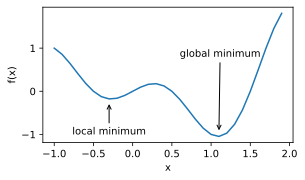

In [2]:
def f(x):
    return x * np.cos(np.pi * x)

set_figsize((4.5, 2.5))
x = np.arange(-1.0, 2.0, 0.1)
fig,  = plt.plot(x, f(x))
fig.axes.annotate('local minimum', xy=(-0.3, -0.25), xytext=(-0.77, -1.0),
                  arrowprops=dict(arrowstyle='->'))
fig.axes.annotate('global minimum', xy=(1.1, -0.95), xytext=(0.6, 0.8),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

#### 7.1.2.2 鞍点

梯度接近或变成零可能是由于当前解在局部最优解附近造成的，另一种可能性是当前解在鞍点（saddle point）附近

$$ f(x)=x^3 $$

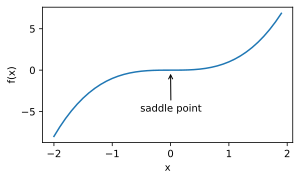

In [3]:
x = np.arange(-2.0, 2.0, 0.1)
fig, = plt.plot(x, x**3)
fig.axes.annotate('saddle point', xy=(0, -0.2), xytext=(-0.52, -5.0),
                  arrowprops=dict(arrowstyle='->'))
plt.xlabel('x')
plt.ylabel('f(x)');

### 小结

- 由于优化算法的目标函数通常是一个基于训练数据集的损失函数，优化的目标在于降低训练误差。
- 由于深度学习模型参数通常都是高维的，目标函数的鞍点通常比局部最小值更常见。

## 7.2 梯度下降和随机梯度下降

### 7.2.1 一维梯度下降

**梯度下降公式推导**

假设连续可导的函数 $f: R→R$ 的输入和输出都是标量。给定绝对值足够小的数 $ϵ$，根据泰勒展开公式，我们得到以下的近似：

$$ f(x + ϵ) ≈ f(x) + ϵf'(x)$$

找到一个常数 $η>0$，使得 $∣ηf′(x)∣$ 足够小，那么可以将 $ϵ = −ηf′(x)$ 得到

$$ f(x−ηf′(x))≈f(x)−ηf′(x)^2$$

如果导数 $ f′(x)≠0 $，那么 $ηf′(x)^2 > 0$，所以

$$ f(x−ηf′(x))≲f(x)$$

这意味着，如果通过 $ x←(x−ηf′(x))$ 来迭代 $x$，函数 $f(x)$ 的值可能会降低


In [4]:
%matplotlib inline
import numpy as np
import torch
import math

In [5]:
def gd(eta):
    x = 10
    results = [x]
    for i in range(10):
        x -= eta * 2 * x  # f(x) = x * x的导数为f'(x) = 2 * x
        results.append(x)
    print('epoch 10, x:', x)
    return results

res = gd(0.2)
print(res)

epoch 10, x: 0.06046617599999997
[10, 6.0, 3.5999999999999996, 2.1599999999999997, 1.2959999999999998, 0.7775999999999998, 0.46655999999999986, 0.2799359999999999, 0.16796159999999993, 0.10077695999999996, 0.06046617599999997]


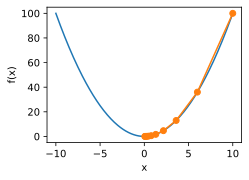

In [6]:
def show_trace(res):
    n = max(abs(min(res)), abs(max(res)), 10)
    f_line = np.arange(-n, n, 0.1)
    set_figsize()
    plt.plot(f_line, [x * x for x in f_line])
    plt.plot(res, [x * x for x in res], '-o')
    plt.xlabel('x')
    plt.ylabel('f(x)')

show_trace(res)

### 7.2.2 学习率

梯度下降算法中的正数 $η$ 通常叫作学习率。这是一个超参数，需要人工设定。如果使用过小的学习率，会导致 $x$ 更新缓慢从而需要更多的迭代才能得到较好的解。

epoch 10, x: 3.4867844009999995


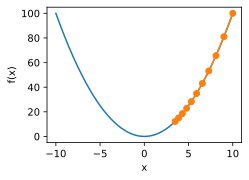

In [7]:
show_trace(gd(0.05))

如果使用过大的学习率，$∣ηf′(x)∣$ 可能会过大从而使前面提到的一阶泰勒展开公式不再成立：这时我们无法保证迭代 $x$ 会降低 $f(x)$ 的值

epoch 10, x: 61.917364224000096


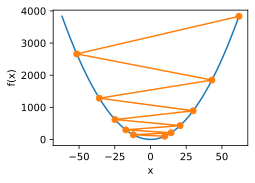

In [8]:
show_trace(gd(1.1))

### 7.2.3 多维梯度下降

目标函数的输入为向量，输出为标量。假设目标函数 $f:R^d→R^f$ 的输入是一个 $d$ 维向量 $x = [x_1, x_2, … , x_d]^⊤$。目标函数 $f(x)$ 有关 $x$ 的梯度是一个由 $d$ 个偏导数组成的向量：

$$ ∇f(x) = \Big[\frac{∂f(x)}{∂x_1},\frac{∂f(x)}{∂x_2},…,\frac{∂f(x)}{∂x_d}\Big]^⊤.$$

梯度中每个偏导数元素 $∂f(x)/∂x_i$ 代表着 $f$ 在 $x$ 有关输入$x_i$ 的变化率。

为了最小化 $f$ ，我们希望找到 $f$ 能被降低最快的方向, 因此，我们可以通过单位向量 $u$ 来最小化方向导数 $D_uf(x)$。

当 $u$ 在梯度方向 $∇f(x)$ 的相反方向时，方向导数 $D_uf(x)$ 被最小化。因此，我们可能通过梯度下降算法来不断降低目标函数 $f$ 的值：

$$ x←x−η∇f(x)$$

In [9]:
def train_2d(trainer):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    x1, x2, s1, s2 = -5, -2, 0, 0  # s1和s2是自变量状态，本章后续几节会使用
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

def show_trace_2d(f, results):  # 本函数将保存在d2lzh_pytorch包中方便以后使用
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 20, x1 -0.057646, x2 -0.000073


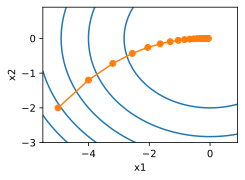

In [10]:
eta = 0.1

def f_2d(x1, x2):  # 目标函数
    return x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

### 7.2.4 随机梯度下降

在深度学习里，目标函数通常是训练数据集中有关各个样本的损失函数的平均

$$ f(x) = \frac{1}{n} \sum_{i=1}^{n} f_i(x)$$

目标函数在 $x$ 处的梯度计算为

$$ ∇f(x) = \frac{1}{n}\sum_{i=1}^{n}∇f_i(x)$$

如果使用梯度下降，每次自变量迭代的计算开销为 $O(n)$，它随着 $n$ 线性增长。因此，当训练数据样本数很大时，梯度下降每次迭代的计算开销很高。

随机梯度下降（stochastic gradient descent，SGD）减少了每次迭代的计算开销。在随机梯度下降的每次迭代中，我们随机均匀采样的一个样本索引 $i∈{1,…,n}$ 并计算梯度 $∇f_i(x)$ 来迭代 $x$：

$$ x←x−η∇fi(x)$$

 这里 $η$ 同样是学习率。可以看到每次迭代的计算开销从梯度下降的 $O(n)$ 降到了常数 $O(1)$

epoch 20, x1 0.107770, x2 0.068513


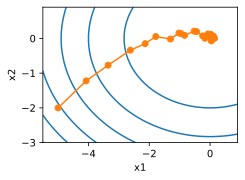

In [11]:
def sgd_2d(x1, x2, s1, s2):
    return (x1 - eta * (2 * x1 + np.random.normal(0.1)),
            x2 - eta * (4 * x2 + np.random.normal(0.1)), 0, 0)

show_trace_2d(f_2d, train_2d(sgd_2d))

### 小结

- 使用适当的学习率，沿着梯度反方向更新自变量可能降低目标函数值。梯度下降重复这一更新过程直到得到满足要求的解。
- 学习率过大或过小都有问题。一个合适的学习率通常是需要通过多次实验找到的。
- 当训练数据集的样本较多时，梯度下降每次迭代的计算开销较大，因而随机梯度下降通常更受青睐。

## 7.3 小批量随机梯度下降

设目标函数 $f(x):R_d→R$。在迭代开始前的时间步设为0。该时间步的自变量记为 $x_0∈R^d$，通常由随机初始化得到。在接下来的每一个时间步 $t>0$ 中，小批量随机梯度下降随机均匀采样一个由训练数据样本索引组成的小批量 $B_t$。我们可以通过重复采样（sampling with replacement）或者不重复采样（sampling without replacement）得到一个小批量中的各个样本。对于这两者间的任一种方式，都可以使用

$$ g_t←∇f_{B_t}(x_{t−1}) = \frac{1}{∣B∣}∑_{i∈B_t}∇f_i(x_{t−1}) $$
来计算时间步 $t$ 的小批量 $B_t$ 上目标函数位于 $x_{t−1}$ 处的梯度 $g_t$。这里 $∣B∣$ 代表批量大小，即小批量中样本的个数，是一个超参数。同随机梯度一样，重复采样所得的小批量随机梯度 $g_t$ 也是对梯度 $∇f(x_{t−1})$的无偏估计。给定学习率 $η_t$（取正数），小批量随机梯度下降对自变量的迭代如下：

$$ x_t←x_{t−1}−η_tg_t$$

基于随机采样得到的梯度的方差在迭代过程中无法减小，因此在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减，例如 $η_t=ηt^α$ （通常α=−1 或者−0.5）、$η_t=ηα^t$ （如α=0.95）或者每迭代若干次后将学习率衰减一次。如此一来，学习率和（小批量）随机梯度乘积的方差会减小。而梯度下降在迭代过程中一直使用目标函数的真实梯度，无须自我衰减学习率。

### 7.3.1 读取数据

In [12]:
%matplotlib inline
import numpy as np
import time
import torch
from torch import nn, optim

def get_data_ch7():  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    data = np.genfromtxt('./data/airfoil_self_noise.dat', delimiter='\t')
    data = (data - data.mean(axis=0)) / data.std(axis=0)
    return torch.tensor(data[:1500, :-1], dtype=torch.float32), \
    torch.tensor(data[:1500, -1], dtype=torch.float32) # 前1500个样本(每个样本5个特征)

features, labels = get_data_ch7()
features.shape # torch.Size([1500, 5])

torch.Size([1500, 5])

### 7.3.2 从零开始实现

In [13]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data -= hyperparams['lr'] * p.grad.data

In [14]:
# 本函数已保存在d2lzh_pytorch包中方便以后使用
def train_ch7(optimizer_fn, states, hyperparams, features, labels,
              batch_size=10, num_epochs=2):
    # 初始化模型
    net, loss = linreg, squared_loss

    w = torch.nn.Parameter(torch.tensor(np.random.normal(0, 0.01, size=(features.shape[1], 1)), dtype=torch.float32),
                           requires_grad=True)
    b = torch.nn.Parameter(torch.zeros(1, dtype=torch.float32), requires_grad=True)

    def eval_loss():
        return loss(net(features, w, b), labels).mean().item()

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            l = loss(net(X, w, b), y).mean()  # 使用平均损失

            # 梯度清零
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()

            l.backward()
            optimizer_fn([w, b], states, hyperparams)  # 迭代模型参数
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())  # 每100个样本记录下当前训练误差
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

loss: 0.245038, 0.008482 sec per epoch


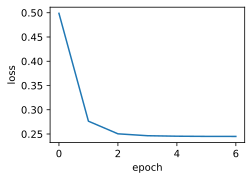

In [15]:
def train_sgd(lr, batch_size, num_epochs=2):
    train_ch7(sgd, None, {'lr': lr}, features, labels, batch_size, num_epochs)

train_sgd(1, 1500, 6)

loss: 0.247584, 0.362457 sec per epoch


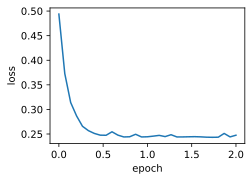

In [16]:
train_sgd(0.005, 1)

loss: 0.244478, 0.046681 sec per epoch


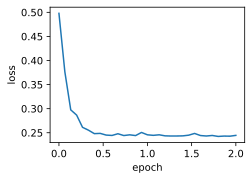

In [17]:
train_sgd(0.05, 10)

### 7.3.3 简洁实现

In [18]:
# 本函数与原书不同的是这里第一个参数优化器函数而不是优化器的名字
# 例如: optimizer_fn=torch.optim.SGD, optimizer_hyperparams={"lr": 0.05}
def train_pytorch_ch7(optimizer_fn, optimizer_hyperparams, features, labels,
                    batch_size=10, num_epochs=2):
    # 初始化模型
    net = nn.Sequential(
        nn.Linear(features.shape[-1], 1)
    )
    loss = nn.MSELoss()
    optimizer = optimizer_fn(net.parameters(), **optimizer_hyperparams)

    def eval_loss():
        return loss(net(features).view(-1), labels).item() / 2

    ls = [eval_loss()]
    data_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(features, labels), batch_size, shuffle=True)

    for _ in range(num_epochs):
        start = time.time()
        for batch_i, (X, y) in enumerate(data_iter):
            # 除以2是为了和train_ch7保持一致, 因为squared_loss中除了2
            l = loss(net(X).view(-1), y) / 2 

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            if (batch_i + 1) * batch_size % 100 == 0:
                ls.append(eval_loss())
    # 打印结果和作图
    print('loss: %f, %f sec per epoch' % (ls[-1], time.time() - start))
    set_figsize()
    plt.plot(np.linspace(0, num_epochs, len(ls)), ls)
    plt.xlabel('epoch')
    plt.ylabel('loss')

loss: 0.244098, 0.047394 sec per epoch


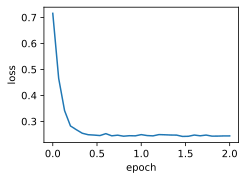

In [19]:
train_pytorch_ch7(optim.SGD, {"lr": 0.05}, features, labels, 10)

### 小结

- 小批量随机梯度每次随机均匀采样一个小批量的训练样本来计算梯度。
- 在实际中，（小批量）随机梯度下降的学习率可以在迭代过程中自我衰减。
- 通常，小批量随机梯度在每个迭代周期的耗时介于梯度下降和随机梯度下降的耗时之间

## 7.4 动量法

目标函数有关自变量的梯度代表了目标函数在自变量当前位置下降最快的方向，在每次迭代中，梯度下降根据自变量当前位置，沿着当前位置的梯度更新自变量。然而，如果自变量的迭代方向仅仅取决于自变量当前位置，这可能会带来一些问题。

### 7.4.1 梯度下降的问题

epoch 20, x1 -0.943467, x2 -0.000073


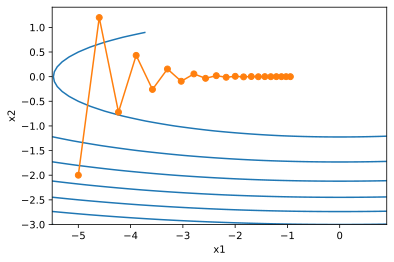

In [20]:
%matplotlib inline
import torch

eta = 0.4 # 学习率

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

可以看到，同一位置上，目标函数在竖直方向（$x_2$ 轴方向）比在水平方向（$x_1$ 轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。那么，我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

**问题: 不同的参数梯度下降的速率不一致，又无法控制**

### 7.4.2 动量法

沿用小批量随机梯度下降中时间步 $t$ 的小批量随机梯度 $g_t$ 的定义。设时间步 $t$ 的自变量为 $x_t$，学习率为 $η_t$。 在时间步 0，动量法创建速度变量 $v_0$，并将其元素初始化成 0。在时间步 $t > 0$，动量法对每次迭代的步骤做如下修改：

$$ v_t←γv_{t−1} + η_tg_t$$ 

$$ x_t←x_{t−1} − v_t $$
 
其中，动量超参数 $γ$ 满足 $0≤γ<1$。当 $γ=0$ 时，动量法等价于小批量随机梯度下降。

epoch 20, x1 -0.062843, x2 0.001202


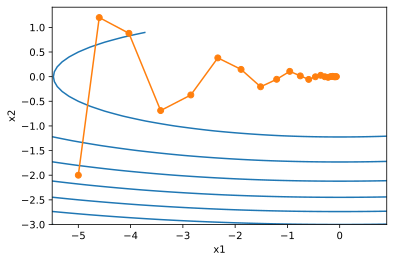

In [21]:
def momentum_2d(x1, x2, v1, v2):
    v1 = gamma * v1 + eta * 0.2 * x1
    v2 = gamma * v2 + eta * 4 * x2
    return x1 - v1, x2 - v2, v1, v2

eta, gamma = 0.4, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

#### 7.4.2.1 指数加权移动平均

指数加权移动平均 (Exponentially Weighted Moving Average, EWMA) : 假设  $v_{t-1}$ 是 $t-1$ 时刻的指数加权移动平均， $\theta_t$ 是 $t$ 时刻的观测值， 那么 $t$ 时刻的指数加权移动平均为

$v_t = \beta v_{t-1} + (1 - \beta)\theta_t = (1 - \beta)\theta_t + \sum_{i=1}^{t-1}(1 - \beta)\beta^i\theta_{t-i}$

其中 $ 0 \le \beta < 1$, $v_0 = 0$ 。显然， 由上式可知， $t$  时刻的指数加权移动平均其实可以看做前 $t$ 时刻所有观测值的指数加权平均，除了第 $t$ 时刻的观测值权重为 $1-\beta$ 外， 其他时刻的观测值权重为 $(1-\beta)\beta^i$。 由于通常对于那些权重小于 $\frac{1}{e}$ 的观测值可以忽略不计，所以忽略掉那些观测值以后，上式就可以看做在求指数加权移动平均。

那么哪些项的权重会小于 $\frac{1}{e}$ 呢？ 由于

$\lim\limits_{n \to +\infty}(1-\frac{1}{n})^n = \frac{1}{e} \approx 0.3679 $

若令 $n = \frac{1}{1-\beta}$, 则

$\lim\limits_{n \to +\infty}(1-\frac{1}{n})^n = \lim\limits_{\beta \to 1}(\beta)^\frac{1}{1-\beta} = \frac{1}{e} \approx 0.3679 $

所以，当 $\beta \to 1$ 时， 那些 $i \ge \frac{1}{1-\beta}$ 的 $\theta_{t-i}$ 的权重 $(1-\beta)\beta^i$ 一定小于 $\frac{1}{e}$ 。例如当 $t = 20$， $\beta = 0.9$ 时， $\theta_1, \theta_2, ..., \theta_9, \theta_{10}$ 的权重都是小于$\frac{1}{e}$ 的，因此可以忽略不计，那么此时就相当于在求 $\theta_{11}, \theta_{12}, ..., \theta_{19}, \theta_{20}$ 这最近10 个时刻的加权移动平均值，所以指数移动平均值可以近似看做在求最近 $\frac{1}{1-\beta}$ 个时刻的加权移动平均值，$\beta$ 常取 $\ge 0.9$

#### 7.4.2.2 由指数加权移动平均理解动量法

Momentum (SGD with Momentum) : 为了抑制 SGD 的震荡， Momentum 认为梯度下降的过程可以加入**惯性**， 也就是在 SGD 基础上引入一阶动量。而所谓的一阶动量就是该时刻梯度的指数加权移动平均： $\eta \cdot m_t = \beta \cdot m_{t-1} + \eta \cdot g_t$ (其中 $g_t$ 并不严格按照指数加权移动平均的定义采用权重 $1-\beta$, 而是使用我们自定义的学习率 $\eta$)。由于此时仍然没有用到二阶动量，所以 $V_t = E$, 那么 Momentum 的参数更新公式为

$\Delta \theta_t = - \eta \cdot \frac{m_t}{\sqrt{E}} = -\eta \cdot m_t = -(\beta m_{t-1} + \eta g_t)$

$\theta_{t+1} = \theta_t - (\beta m_{t-1} + \eta g_t)$

### 7.4.3 从零开始实现

In [22]:
features, labels = get_data_ch7()

def init_momentum_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        v.data = hyperparams['momentum'] * v.data + hyperparams['lr'] * p.grad.data
        p.data -= v.data

loss: 0.242660, 0.048873 sec per epoch


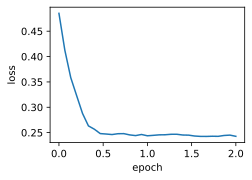

In [23]:
train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.5}, features, labels)

loss: 0.270355, 0.049307 sec per epoch


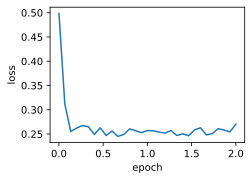

In [24]:
train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.02, 'momentum': 0.9}, features, labels)

loss: 0.243565, 0.049237 sec per epoch


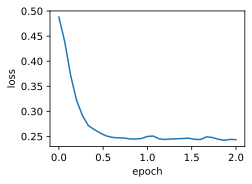

In [25]:
train_ch7(sgd_momentum, init_momentum_states(),
              {'lr': 0.004, 'momentum': 0.9}, features, labels)

### 7.4.4 简洁实现

loss: 0.241986, 0.052106 sec per epoch


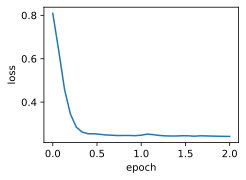

In [26]:
train_pytorch_ch7(torch.optim.SGD, {'lr': 0.004, 'momentum': 0.9},
                    features, labels)

### 小结

- 动量法使用了指数加权移动平均的思想。它将过去时间步的梯度做了加权平均，且权重按时间步指数衰减。
- 动量法使得相邻时间步的自变量更新在方向上更加一致。

## 7.5 AdaGrad算法

- 当 $x_1$ 和 $x_2$ 的梯度值有较大差别时，需要选择足够小的学习率使得自变量在梯度值较大的维度上收敛。但这样会导致自变量在梯度值较小的维度上迭代过慢。
- 动量法依赖指数加权移动平均使得自变量的更新方向更加一致，从而降低发散的可能。
- AdaGrad算法根据自变量在每个维度的梯度值的大小来调整各个维度上的学习率，从而避免统一的学习率难以适应所有维度的问题

### 7.5.1 算法

AdaGrad 算法会使用一个小批量随机梯度 $g_t$ 按元素平方的累加变量 $s_t$ 。在时间步0，AdaGrad将 $s_0$ 中每个元素初始化为 0。在时间步 $t$，首先将小批量随机梯度 $g_t$ 按元素平方后累加到变量 $s_t$ ：

$$ s_t←s_{t−1} + g_t⊙g_t$$

其中 $⊙$ 是按元素相乘。接着，我们将目标函数自变量中每个元素的学习率通过按元素运算重新调整一下：

$$ x_t←x_{t−1}−\frac{η}{\sqrt{s_t + ϵ}}⊙g_t$$

其中 $η$ 是学习率，$ϵ$ 是为了维持数值稳定性而添加的常数，如$10^{−6}$ 。这里开方、除法和乘法的运算都是按元素运算的。这些按元素运算使得目标函数自变量中每个元素都分别拥有自己的学习率。

### 7.5.2 特点

小批量随机梯度按元素平方的累加变量 $s_t$  出现在学习率的分母项中。因此，如果目标函数有关自变量中某个元素的偏导数一直都较大，那么该元素的学习率将下降较快；反之，如果目标函数有关自变量中某个元素的偏导数一直都较小，那么该元素的学习率将下降较慢。然而，由于 $s_t$ 一直在累加按元素平方的梯度，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。所以，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad 算法在迭代后期由于学习率过小，可能较难找到一个有用的解。

epoch 20, x1 -2.382563, x2 -0.158591


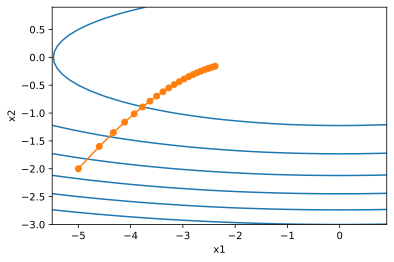

In [27]:
%matplotlib inline
import math
import torch

def adagrad_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6  # 前两项为自变量梯度
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

epoch 20, x1 -0.002295, x2 -0.000000


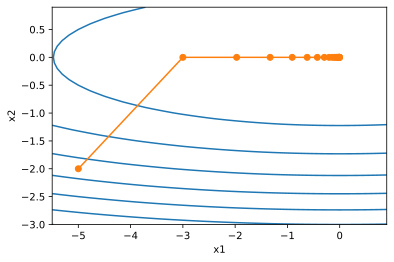

In [28]:
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

### 7.5.3 从零开始实现

In [29]:
features, labels = get_data_ch7()

def init_adagrad_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        s.data += (p.grad.data**2)
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.242682, 0.056070 sec per epoch


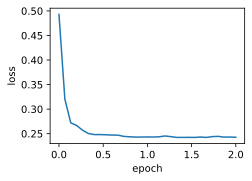

In [30]:
train_ch7(adagrad, init_adagrad_states(), {'lr': 0.1}, features, labels)

### 7.5.4 简洁实现

loss: 0.244074, 0.054535 sec per epoch


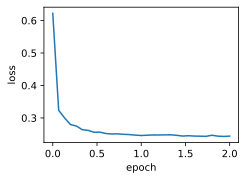

In [31]:
train_pytorch_ch7(torch.optim.Adagrad, b features, labels)

### 小结

- AdaGrad算法在迭代过程中不断调整学习率，并让目标函数自变量中每个元素都分别拥有自己的学习率。
- 使用AdaGrad算法时，自变量中每个元素的学习率在迭代过程中一直在降低（或不变）。

## 7.6 RMSProp算法

### 7.6.1 算法

不同于AdaGrad算法里状态变量 $s_t$ 是截至时间步 $t$ 所有小批量随机梯度 $g_t$ 按元素平方和，RMSProp算法将这些梯度按元素平方做指数加权移动平均。具体来说，给定超参数 $0≤γ<1$，RMSProp算法在时间步 $t>0$ 计算

$$ s_t←γs_{t−1} + (1−γ)g_t⊙g_t$$

和AdaGrad算法一样，RMSProp算法将目标函数自变量中每个元素的学习率通过按元素运算重新调整，然后更新自变量

$$ x_t←x_{t−1}−\frac{η}{\sqrt{s_t + ϵ}}⊙g_t$$

其中 $η$ 是学习率，$ϵ$ 是为了维持数值稳定性而添加的常数，如$10^{−6}$ 。因为RMSProp算法的状态变量 $s_t$ 是对平方项$g_t⊙g_t$ 的指数加权移动平均，所以可以看作是最近 $1/(1−γ)$ 个时间步的小批量随机梯度平方项的加权平均。如此一来，自变量每个元素的学习率在迭代过程中就不再一直降低（或不变）。

epoch 20, x1 -0.010599, x2 0.000000


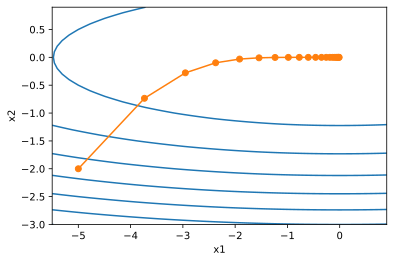

In [32]:
%matplotlib inline
import math
import torch

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

### 7.6.2 从零开始实现

In [34]:
features, labels = get_data_ch7()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.242643, 0.061203 sec per epoch


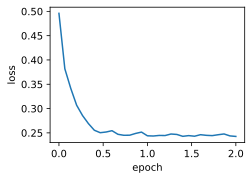

In [35]:
train_ch7(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
              features, labels)

### 7.6.3 简洁实现

loss: 0.247132, 0.056998 sec per epoch


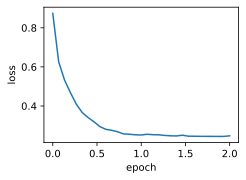

In [36]:
train_pytorch_ch7(torch.optim.RMSprop, {'lr': 0.01, 'albpha': 0.9},
                    features, labels)

### 小结

- RMSProp算法和AdaGrad算法的不同在于，RMSProp算法使用了小批量随机梯度按元素平方的指数加权移动平均来调整学习率。

## 7.7 AdaDelta算法

除了RMSProp算法以外，另一个常用优化算法AdaDelta算法也针对AdaGrad算法在迭代后期可能较难找到有用解的问题做了改进。AdaDelta算法没有学习率这一超参数。

### 7.7.1 算法

AdaDelta算法也像RMSProp算法一样，使用了小批量随机梯度 $g_t$ 按元素平方的指数加权移动平均变量 $s_t$ 。在时间步 0，它的所有元素被初始化为 0。给定超参数 $0≤ρ<1$（对应RMSProp算法中的 $γ$），在时间步 $t>0$，同RMSProp算法一样计算

$$ s_t←ρs_{t−1} + (1−ρ)g_t⊙g_t$$

与RMSProp算法不同的是，AdaDelta算法还维护一个额外的状态变量 $Δx_t$ ，其元素同样在时间步 0 时被初始化为 0。我们使用 $Δx_{t−1}$ 来计算自变量的变化量：

$$ g't←\sqrt{\frac{Δx_{t−1} + ϵ}{s_t + ϵ}}⊙g_t$$

其中 $ϵ$ 是为了维持数值稳定性而添加的常数，如 $10^{−5}$。接着更新自变量：

$$ x_t←x_{t−1}−g't$$

最后，我们使用 $Δx_t$ 来记录自变量变化量 $g't$ 按元素平方的指数加权移动平均：

$$ Δxt←ρΔxt−1+(1−ρ)g′t⊙g′t$$

可以看到，如不考虑ϵϵ的影响，AdaDelta算法跟RMSProp算法的不同之处在于使用 $\sqrt{Δx_{t−1}}$  来替代学习率 $η$。

### 7.7.2 从零开始实现

In [42]:
%matplotlib inline
import torch

features, labels = get_data_ch7()

def init_adadelta_states():
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    delta_w, delta_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * (p.grad.data**2)
        g =  p.grad.data * torch.sqrt((delta + eps) / (s + eps))
        p.data -= g
        delta[:] = rho * delta + (1 - rho) * g * g

loss: 0.244153, 0.068579 sec per epoch


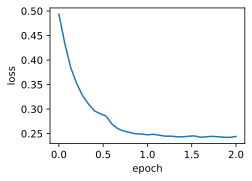

In [43]:
train_ch7(adadelta, init_adadelta_states(), {'rho': 0.9}, features, labels)

### 7.7.3 简洁实现

loss: 0.256620, 0.062330 sec per epoch


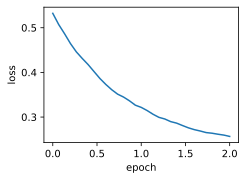

In [44]:
train_pytorch_ch7(torch.optim.Adadelta, {'rho': 0.9}, features, labels)

### 小结

- AdaDelta算法没有学习率超参数，它通过使用有关自变量更新量平方的指数加权移动平均的项来替代RMSProp算法中的学习率。

## 7.8 Adam算法

Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均

Adam算法使用了动量变量 $v_t$ 和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量 $s_t$，并在时间步 0 将它们中每个元素初始化为 0。给定超参数 $0≤β_1<1$（算法作者建议设为0.9），时间步 $t$ 的动量变量 $v_t$ 即小批量随机梯度 $g_t$ 的指数加权移动平均：

$$ v_t←β_1v_{t−1} + (1−β_1)g_t $$

和RMSProp算法中一样，给定超参数 $0≤β_2<1$（算法作者建议设为0.999）， 将小批量随机梯度按元素平方后的项 $g_t⊙g_t$ 做指数加权移动平均得到 $s_t$ ：

$$ s_t←β_2s_{t−1} + (1−β_2)g_t⊙g_t$$

由于我们将 $v_0$ 和 $s_0$ 中的元素都初始化为 0， 在时间步 $t$ 我们得到 $v_t=(1−β_1)\sum_{i=1}^{t}β^{t−i}_1g_i$ 。将过去各时间步小批量随机梯度的权值相加，得到 $(1−β_1)\sum_{i=1}^{t}β^{t−i}_{1}=1−β^{t}_{1}$ 。需要注意的是，当 $t$ 较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$β_1=0.9$ 时，$v_1=0.1g_1$ 。为了消除这样的影响，对于任意时间步 $t$，我们可以将 $v_t$ 再除以$1−β^{t}_{1}$ ，从而使过去各时间步小批量随机梯度权值之和为 1。这也叫作偏差修正。在Adam算法中，我们对变量 $v_t$ 和 $s_t$ 均作偏差修正：

$$ \hat{v_t}←\frac{v_t}{1−β^{t}_{1}}$$
$$ \hat{s_t}←\frac{st}{1−β^{t}_{2}}$$

接下来，Adam算法使用以上偏差修正后的变量$\hat{v_t} $ 和 $\hat{s_t}$  ，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$ g'_t←\frac{η\hat{v_t}}{\sqrt{\hat{s_t} + ϵ}}$$
 ,
其中 $η$ 是学习率，$ϵ$ 是为了维持数值稳定性而添加的常数，如 $10^{−8}$ 。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用 $g't$ 迭代自变量：

$$ x_t←x_{t−1}−g'_t$$

### 7.8.2 从零开始实现

In [46]:
%matplotlib inline
import torch

features, labels = get_data_ch7()

def init_adam_states():
    v_w, v_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    s_w, s_b = torch.zeros((features.shape[1], 1), dtype=torch.float32), torch.zeros(1, dtype=torch.float32)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
    hyperparams['t'] += 1

loss: 0.246131, 0.072355 sec per epoch


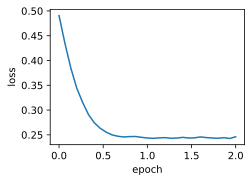

In [47]:
train_ch7(adam, init_adam_states(), {'lr': 0.01, 't': 1}, features, labels)

### 7.8.3 简洁实现

loss: 0.244377, 0.061436 sec per epoch


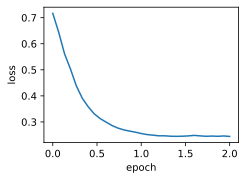

In [48]:
train_pytorch_ch7(torch.optim.Adam, {'lr': 0.01}, features, labels)

### 小结

- Adam算法在RMSProp算法的基础上对小批量随机梯度也做了指数加权移动平均。
- Adam算法使用了偏差修正。